# Import all necessary libraries. 

In [1]:
pip install nltk

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tabulate

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import warnings
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.parsing.preprocessing import preprocess_string
from gensim import corpora
from gensim.models import LdaModel
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import percentileofscore
from nltk import pos_tag
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.classify import NaiveBayesClassifier
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from nltk.probability import FreqDist
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
warnings.filterwarnings("ignore")
from tabulate import tabulate

# Summary

## This Jupyter notebook focuses on conducting Sentiment Analysis separately on two dataframes.

## Initially, we'll perform Sentiment Analysis on each dataframe without additional preprocessing steps like stopword removal, word stemming, or word tokenization. Subsequently, we'll repeat the sentiment analysis process after applying these preprocessing techniques. Following this, we'll juxtapose the results obtained from both dataframes and delve into their implications.

## Additionally, we'll identify the top positive, negative, and neutral tweets within each dataframe.

# Read the file involving Critic reviews and shows (ModifiedCritic.csv)

In [41]:
modified_critics_df = pd.read_csv("D:/Spring 2024 notes/Social Media Analytics/SMA_Project/ModifiedCritic.csv")
print(modified_critics_df.head())

   Unnamed: 0              Show  Sentiment  \
0           0  Mare of Easttown          1   
1           1  Mare of Easttown          1   
2           2  Mare of Easttown          1   
3           3  Mare of Easttown          1   
4           4  Mare of Easttown          1   

                                              Review  Network Critic Score  \
0  I’m not sure I have engaged in appointment vie...  HBO MAX          95%   
1  Kate is marvelous; she truly is Mare. She disa...  HBO MAX          95%   
2  That’s the thing I’ve loved most about Mare: t...  HBO MAX          95%   
3  Boasting Kate Winslet in the title role, twist...  HBO MAX          95%   
4  Performances in which madness, psychopathy or ...  HBO MAX          95%   

  Audience Score  Critic Review Count  
0            94%                  127  
1            94%                  127  
2            94%                  127  
3            94%                  127  
4            94%                  127  


###  Data Preprocessing: Removing unwanted data. 

In [5]:
modified_critics_df = modified_critics_df.drop(columns=['Unnamed: 0'])
print(modified_critics_df.head())

               Show  Sentiment  \
0  Mare of Easttown          1   
1  Mare of Easttown          1   
2  Mare of Easttown          1   
3  Mare of Easttown          1   
4  Mare of Easttown          1   

                                              Review  Network Critic Score  \
0  I’m not sure I have engaged in appointment vie...  HBO MAX          95%   
1  Kate is marvelous; she truly is Mare. She disa...  HBO MAX          95%   
2  That’s the thing I’ve loved most about Mare: t...  HBO MAX          95%   
3  Boasting Kate Winslet in the title role, twist...  HBO MAX          95%   
4  Performances in which madness, psychopathy or ...  HBO MAX          95%   

  Audience Score  Critic Review Count  
0            94%                  127  
1            94%                  127  
2            94%                  127  
3            94%                  127  
4            94%                  127  


### Observing columns.

In [6]:
print(modified_critics_df[['Show','Review']])

                   Show                                             Review
0      Mare of Easttown  I’m not sure I have engaged in appointment vie...
1      Mare of Easttown  Kate is marvelous; she truly is Mare. She disa...
2      Mare of Easttown  That’s the thing I’ve loved most about Mare: t...
3      Mare of Easttown  Boasting Kate Winslet in the title role, twist...
4      Mare of Easttown  Performances in which madness, psychopathy or ...
...                 ...                                                ...
19783         Dinosaurs  Although the show was lighthearted and geared ...
19784         Dinosaurs  The series finale of the family-friendly dino ...
19785         Dinosaurs     [Dinosaurs] was the very pinnacle of hilarity.
19786         Dinosaurs  For all its rounded-off edges and at-times-uns...
19787         Dinosaurs  As one might expect, some [episodes] are bette...

[19788 rows x 2 columns]


### Calculating the critic review counts for each show.

In [7]:
show_review_counts = modified_critics_df['Show'].value_counts()

print("Number of reviews for each show:")
print(show_review_counts)

Number of reviews for each show:
The Haunting of Hill House       309
Breaking Bad                     294
Succession                       279
True Detective                   273
Mare of Easttown                 254
                                ... 
Love & Anarchy                     1
8 Simple Rules                     1
Roswell, New Mexico                1
Fear the Walking Dead              1
RuPaul's Drag Race: All Stars      1
Name: Show, Length: 495, dtype: int64


### Checking how many shows have critic reviews less than or equal to 5 .

In [8]:
single_review_shows = (show_review_counts <= 5).sum()
print("\nNumber of shows with less than or equal to 5 reviews:", single_review_shows)


Number of shows with less than or equal to 5 reviews: 62


In [9]:
sum_review_shows = show_review_counts.sum()
print("Sum of all the show reviews:", sum_review_shows)

Sum of all the show reviews: 19788


### Printing the top 30 shows having the highest number of critic reviews.

In [10]:
sorted_show_review_counts = show_review_counts.sort_values(ascending=False)

top_n = 30 
top_shows = sorted_show_review_counts.head(top_n)
print(f"Top {top_n} shows with the highest number of reviews:")
print(top_shows)

Top 30 shows with the highest number of reviews:
The Haunting of Hill House    309
Breaking Bad                  294
Succession                    279
True Detective                273
Mare of Easttown              254
The Office                    232
Yellowjackets                 219
Taboo                         201
The Staircase                 198
Fleabag                       196
Marvel's Daredevil            195
WandaVision                   192
The White Lotus               186
You                           168
Fargo                         168
We Own This City              156
The Boys                      154
Barry                         153
Lovecraft Country             141
The Leftovers                 138
House of Cards                136
The Wire                      132
Sharp Objects                 130
Loki                          130
Stranger Things               128
Euphoria                      123
Mad Men                       122
Moon Knight                   121

### Data Filtering and Analysis for top shows. 

In [11]:
filtered_reviews = modified_critics_df[modified_critics_df['Show'].isin(top_shows.index)]
print("Unique Show Names in Filtered DataFrame:")
print(filtered_reviews['Show'].unique())

unique_reviews_count = filtered_reviews.groupby('Show')['Review'].nunique().reset_index()
unique_reviews_count = unique_reviews_count.rename(columns={'Review': 'Unique_Reviews_Count'})
print("\nUnique Reviews Count for Top Shows:")
print(unique_reviews_count)

Unique Show Names in Filtered DataFrame:
['Mare of Easttown' 'Barry' "The Time Traveler's Wife" 'We Own This City'
 'The Staircase' 'Euphoria' 'Succession' 'The Wire' 'True Detective'
 'The Leftovers' 'The White Lotus' 'Sharp Objects' 'Lovecraft Country'
 'Yellowjackets' "Marvel's Daredevil" 'The Boys' 'Breaking Bad' 'Fleabag'
 'The Office' 'You' 'Fargo' 'Taboo' 'The Haunting of Hill House' 'Mad Men'
 'House of Cards' 'Stranger Things' 'Moon Knight' 'Loki' 'WandaVision'
 'The Beatles: Get Back']

Unique Reviews Count for Top Shows:
                          Show  Unique_Reviews_Count
0                        Barry                    51
1                 Breaking Bad                    98
2                     Euphoria                    41
3                        Fargo                    56
4                      Fleabag                    98
5               House of Cards                    68
6                         Loki                   130
7            Lovecraft Country        

### Dataset information.

In [12]:
print("\nFiltered DataFrame Info:")
print(filtered_reviews.info())


Filtered DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5368 entries, 0 to 19373
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Show                 5368 non-null   object
 1   Sentiment            5368 non-null   int64 
 2   Review               5368 non-null   object
 3   Network              5368 non-null   object
 4   Critic Score         5368 non-null   object
 5   Audience Score       5368 non-null   object
 6   Critic Review Count  5368 non-null   int64 
dtypes: int64(2), object(5)
memory usage: 335.5+ KB
None


# Sentiment Analysis

### Sentiment Analysis of Critic Reviews for Top 30 shows using VADER. 

In [13]:
sia = SentimentIntensityAnalyzer()
def calculate_sentiment_vader(text):
    scores = sia.polarity_scores(text)
    return scores 

filtered_reviews['Sentiment_VADER'] = filtered_reviews['Review'].apply(calculate_sentiment_vader)
filtered_reviews = pd.concat([filtered_reviews.drop(['Sentiment_VADER'], axis=1),
                              filtered_reviews['Sentiment_VADER'].apply(pd.Series)], axis=1)

for show_name, group in filtered_reviews.groupby('Show'):
    print(f"Show: {show_name}")
    print("\n")
    sample_reviews = group.sample(n=10, random_state=1) 
    for index, row in sample_reviews.iterrows():
        print(f"Review: {row['Review']}")
        print(f"Sentiment Scores (VADER):")
        print(f"Compound: {row['compound']:.2f}, Positive: {row['pos']:.2f}, Negative: {row['neg']:.2f}, Neutral: {row['neu']:.2f}")
        print("---------------------------")
    print("\n--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
    print("\n")

Show: Barry


Review: While previous seasons asked if it was possible to change, or if Barry is doomed to a life of violence, this season is firmly dealing with consequences.
Sentiment Scores (VADER):
Compound: -0.85, Positive: 0.00, Negative: 0.26, Neutral: 0.74
---------------------------
Review: In Season 3, the comic drama gets as dark and morally knotty as Better Call Saul. Like Bob Odenkirk’s Saul, Hader’s Barry proves that an SNL funnyman can turn out to be one of the great dramatic actors on TV.
Sentiment Scores (VADER):
Compound: 0.90, Positive: 0.25, Negative: 0.00, Neutral: 0.75
---------------------------
Review: Comedy lets Barry’s writers and performers deftly field all of these complex feelings, the fact that violence is abhorrent and yet compelling to watch, without feeling like it’s moralizing. Every squirm comes with an equally big laugh.
Sentiment Scores (VADER):
Compound: -0.57, Positive: 0.16, Negative: 0.23, Neutral: 0.60
---------------------------
Review: Season

### Sentiment Analysis scores for top 5 positive, negative and neutral critic reviews for each show. 

In [14]:
def select_top_reviews(group, sentiment_type, top_n=5, highlight_threshold=0.5):
    group_unique = group.drop_duplicates(subset='Review')
    if len(group_unique) == 0:
        return pd.DataFrame()
    sorted_reviews = group_unique.sort_values(by=sentiment_type, ascending=False)
    top_reviews = sorted_reviews.head(top_n)
    return top_reviews

def print_reviews_with_scores(reviews):
    for index, row in reviews.iterrows():
        print(f"Review: {row['Review']}")
        print(f"Sentiment Scores: Compound: {row['compound']:.2f}, Positive: {row['pos']:.2f}, Negative: {row['neg']:.2f}, Neutral: {row['neu']:.2f}")
        print("---------------------------")

for show_name, group in filtered_reviews.groupby('Show'):
    print(f"Show: {show_name}")
    
    top_positive_reviews = select_top_reviews(group, 'pos')
    print("\nTop Positive Reviews:")
    print_reviews_with_scores(top_positive_reviews)
    
    top_negative_reviews = select_top_reviews(group, 'neg')
    print("\nTop Negative Reviews:")
    print_reviews_with_scores(top_negative_reviews)
    
    top_neutral_reviews = select_top_reviews(group, 'neu')
    print("\nTop Neutral Reviews:")
    print_reviews_with_scores(top_neutral_reviews)
    
    print("\n--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
    print("\n")

Show: Barry

Top Positive Reviews:
Review: Barry is simply a masterpiece of deeply humane, hilarious satire.
Sentiment Scores: Compound: 0.80, Positive: 0.50, Negative: 0.00, Neutral: 0.50
---------------------------
Review: This half-hour comedy is still one of television’s best suspense-filled thrillers.
Sentiment Scores: Compound: 0.78, Positive: 0.49, Negative: 0.00, Neutral: 0.51
---------------------------
Review: I care about so much of Barry that I don’t care about the things that I don’t care about.
Sentiment Scores: Compound: 0.86, Positive: 0.42, Negative: 0.00, Neutral: 0.57
---------------------------
Review: In Season 3, the show has fully outgrown its cutesy premise to become one of TV's best thrill rides.
Sentiment Scores: Compound: 0.88, Positive: 0.39, Negative: 0.00, Neutral: 0.61
---------------------------
Review: Every element works together seamlessly to deliver brisk, packed, profound, emotional, disturbing, and hilarious half-hour episodes that are so delectabl

### Printing the compound Sentiment scores for each show.

In [15]:
# sia = SentimentIntensityAnalyzer()

# def calculate_sentiment_vader(text):
#     scores = sia.polarity_scores(text)
#     return scores['compound']  

# modified_critics_df['Sentiment_VADER'] = modified_critics_df['Review'].apply(calculate_sentiment_vader)
# average_sentiment_scores = modified_critics_df.groupby('Show')['Sentiment_VADER'].mean().reset_index()
# modified_critics_df = average_sentiment_scores.rename(columns={'Sentiment_VADER': 'Critic Sentiment scores'})
# modified_critics_df['Critic Sentiment scores'] = modified_critics_df['Critic Sentiment scores'].round(3)

# pd.set_option('display.max_rows', None)
# print(tabulate(modified_critics_df, headers='keys', tablefmt='grid'))


In [36]:
sia = SentimentIntensityAnalyzer()

def calculate_sentiment_vader(text):
    sia = SentimentIntensityAnalyzer()
    scores = sia.polarity_scores(text)
    return scores['compound']  

# Apply sentiment analysis to each review
modified_critics_df['Sentiment_VADER'] = modified_critics_df['Review'].apply(calculate_sentiment_vader)

# Group by show and calculate the average sentiment score
average_sentiment_scores = modified_critics_df.groupby('Show')['Sentiment_VADER'].mean().reset_index()
average_sentiment_scores = average_sentiment_scores.rename(columns={'Sentiment_VADER': 'Critic Sentiment Scores'})
average_sentiment_scores['Critic Sentiment Scores'] = average_sentiment_scores['Critic Sentiment Scores'].round(3)

# Create a new DataFrame to store the average sentiment scores
critic_sentiment_df = average_sentiment_scores.copy()

# Print the average sentiment scores for each show
print(tabulate(critic_sentiment_df, headers='keys', tablefmt='grid'))

+-----+-------------------------------------------------+---------------------------+
|     | Show                                            |   Critic Sentiment Scores |
+=====+=================================================+===========================+
|   0 | 11.22.63                                        |                     0.384 |
+-----+-------------------------------------------------+---------------------------+
|   1 | 13 Reasons Why                                  |                    -0.249 |
+-----+-------------------------------------------------+---------------------------+
|   2 | 1883                                            |                     0.244 |
+-----+-------------------------------------------------+---------------------------+
|   3 | 1971: The Year That Music Changed Everything    |                     0.355 |
+-----+-------------------------------------------------+---------------------------+
|   4 | 24                                            

### Text Preprocessing with NLTK. 

In [17]:
nltk.download('punkt')
nltk.download('stopwords')

stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [token.lower() for token in tokens]

    preprocessed_tokens = []
    for token in tokens:
        if token.isalpha() and token not in stop_words:
            stemmed_token = stemmer.stem(token)
            preprocessed_tokens.append(stemmed_token)

    preprocessed_text = ' '.join(preprocessed_tokens)
    return preprocessed_text

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\adija\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\adija\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Sentiment Analysis for Top Shows on preprocessed critic reviews. 

In [18]:
modified_critics_df['Preprocessed_Review'] = modified_critics_df['Review'].apply(preprocess_text)
filtered_reviews = modified_critics_df[modified_critics_df['Show'].isin(top_shows.index)]

sia = SentimentIntensityAnalyzer()
def calculate_sentiment_vader(text):
    scores = sia.polarity_scores(text)
    return scores 

filtered_reviews['Sentiment_VADER'] = filtered_reviews['Preprocessed_Review'].apply(calculate_sentiment_vader)
filtered_reviews = pd.concat([filtered_reviews.drop(['Sentiment_VADER'], axis=1),
                              filtered_reviews['Sentiment_VADER'].apply(pd.Series)], axis=1)

for show_name, group in filtered_reviews.groupby('Show'):
    print(f"Show: {show_name}")
    sample_reviews = group.sample(n=5, random_state=1) 
    for index, row in sample_reviews.iterrows():
        print(f"Review: {row['Preprocessed_Review']}")
        print(f"Sentiment Scores (VADER):")
        print(f"Compound: {row['compound']:.2f}, Positive: {row['pos']:.2f}, Negative: {row['neg']:.2f}, Neutral: {row['neu']:.2f}")
        print("---------------------------")
    print("\n--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")

Show: Barry
Review: previou season ask possibl chang barri doom life violenc season firmli deal consequ
Sentiment Scores (VADER):
Compound: -0.40, Positive: 0.00, Negative: 0.18, Neutral: 0.82
---------------------------
Review: season comic drama get dark moral knotti better call saul like bob odenkirk saul hader barri prove snl funnyman turn one great dramat actor tv
Sentiment Scores (VADER):
Compound: 0.90, Positive: 0.36, Negative: 0.00, Neutral: 0.64
---------------------------
Review: comedi let barri writer perform deftli field complex feel fact violenc abhorr yet compel watch without feel like moral everi squirm come equal big laugh
Sentiment Scores (VADER):
Compound: 0.36, Positive: 0.12, Negative: 0.07, Neutral: 0.80
---------------------------
Review: season everi bit uproari unhing ever dark part dark comedi slowli close
Sentiment Scores (VADER):
Compound: 0.00, Positive: 0.00, Negative: 0.00, Neutral: 1.00
---------------------------
Review: even though wait three year epi

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Read the file involving Critic reviews and shows (ModifiedAudience.csv)

In [40]:
modified_audience_df = pd.read_csv("D:/Spring 2024 notes/Social Media Analytics/SMA_Project/ModifiedAudience.csv")
print(modified_audience_df.head())

   Unnamed: 0  Show  Rating  \
0           0  Loot     2.5   
1           1  Loot     4.5   
2           2  Loot     0.5   
3           3  Loot     4.5   
4           4  Loot     0.5   

                                              Review    Network Critic Score  \
0  I love the stars, but the show is riddled with...  Apple TV+          80%   
1  Great show to watch. It's something that's eas...  Apple TV+          80%   
2  Another Apple tanker crashes into the reef wit...  Apple TV+          80%   
3  This is such a fun, endearing show.  It has a ...  Apple TV+          80%   
4  Terrible show - didn't laugh once. Acting is s...  Apple TV+          80%   

  Audience Score  Review Count  
0            65%            21  
1            65%            21  
2            65%            21  
3            65%            21  
4            65%            21  


In [20]:
modified_audience_df = modified_audience_df.drop(columns=['Unnamed: 0'])
print(modified_audience_df.head())

   Show  Rating                                             Review    Network  \
0  Loot     2.5  I love the stars, but the show is riddled with...  Apple TV+   
1  Loot     4.5  Great show to watch. It's something that's eas...  Apple TV+   
2  Loot     0.5  Another Apple tanker crashes into the reef wit...  Apple TV+   
3  Loot     4.5  This is such a fun, endearing show.  It has a ...  Apple TV+   
4  Loot     0.5  Terrible show - didn't laugh once. Acting is s...  Apple TV+   

  Critic Score Audience Score  Review Count  
0          80%            65%            21  
1          80%            65%            21  
2          80%            65%            21  
3          80%            65%            21  
4          80%            65%            21  


In [21]:
modified_audience_df.shape

(93195, 7)

In [22]:
show_review_counts_audience = modified_audience_df['Show'].value_counts()

print("Number of reviews for each show:")
print(show_review_counts_audience)

Number of reviews for each show:
Game of Thrones                10395
Watchmen                        2576
The Haunting of Hill House      2472
Altered Carbon                  2316
The Witcher                     2200
                               ...  
The Big Conn                       1
A Wilderness of Error              1
Wellington Paranormal              1
Chicago Fire                       1
The Villains of Valley View        1
Name: Show, Length: 562, dtype: int64


In [23]:
sum_review_counts_audience = show_review_counts_audience.sum()
print("Sum of all the show reviews:", sum_review_counts_audience)

Sum of all the show reviews: 93195


### Printing the top 30 shows having the highest number of audience reviews.

In [24]:
sorted_show_review_counts = show_review_counts_audience.sort_values(ascending=False)

top_n = 30 
top_shows = sorted_show_review_counts.head(top_n)
print(f"Top {top_n} shows with the highest number of reviews:")
print(top_shows)

Top 30 shows with the highest number of reviews:
Game of Thrones                      10395
Watchmen                              2576
The Haunting of Hill House            2472
Altered Carbon                        2316
The Witcher                           2200
WandaVision                           1940
Breaking Bad                          1800
Halo                                  1782
Arcane: League of Legends             1724
The Falcon and the Winter Soldier     1642
Marvel's Daredevil                    1617
Loki                                  1557
The Book of Boba Fett                 1482
Obi-Wan Kenobi                        1479
Star Trek: Picard                     1461
Star Trek: Discovery                  1413
Ms. Marvel                            1230
Moon Knight                           1164
Heartstopper                          1100
Squid Game                            1015
Stranger Things                        932
The Mandalorian                        871
Rick 

### Data Filtering and Analysis for top shows.

In [25]:
filtered_reviews_audience = modified_audience_df[modified_audience_df['Show'].isin(top_shows.index)]
print("Unique Show Names in Filtered DataFrame:")
print(filtered_reviews_audience['Show'].unique())

unique_reviews_count_audience = filtered_reviews_audience.groupby('Show')['Review'].nunique().reset_index()
unique_reviews_count_audience = unique_reviews_count_audience.rename(columns={'Review': 'Unique_Reviews_Count'})
print("\nUnique Reviews Count for Top Shows:")
print(unique_reviews_count_audience)

Unique Show Names in Filtered DataFrame:
['Halo' 'Avatar: The Last Airbender' 'Star Trek: Discovery'
 'Star Trek: Picard' 'Game of Thrones' 'Rick and Morty'
 "Marvel's Daredevil" 'Fargo' 'The Haunting of Hill House'
 'Altered Carbon' '13 Reasons Why' 'Breaking Bad' 'Stranger Things'
 'Heartstopper' 'Dark' 'Arcane: League of Legends' 'Squid Game'
 'The Witcher' "The Queen's Gambit" 'Peacemaker' 'Watchmen'
 'Obi-Wan Kenobi' 'Ms. Marvel' 'Moon Knight' 'The Mandalorian'
 'The Book of Boba Fett' 'Loki' 'WandaVision' 'What If...?'
 'The Falcon and the Winter Soldier']

Unique Reviews Count for Top Shows:
                                 Show  Unique_Reviews_Count
0                      13 Reasons Why                   265
1                      Altered Carbon                   772
2           Arcane: League of Legends                  1724
3          Avatar: The Last Airbender                   169
4                        Breaking Bad                   600
5                                D

### Dataset information. 

In [26]:
print("\nFiltered DataFrame Info:")
print(filtered_reviews_audience.info())


Filtered DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 49903 entries, 3170 to 90794
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Show            49903 non-null  object 
 1   Rating          49903 non-null  float64
 2   Review          49903 non-null  object 
 3   Network         49903 non-null  object 
 4   Critic Score    49903 non-null  object 
 5   Audience Score  49903 non-null  object 
 6   Review Count    49903 non-null  int64  
dtypes: float64(1), int64(1), object(5)
memory usage: 3.0+ MB
None


# Sentiment Analysis.

### Sentiment Analysis of Critic Reviews for Top 30 shows using VADER.

In [27]:
sia = SentimentIntensityAnalyzer()
def calculate_sentiment_vader(text):
    scores = sia.polarity_scores(text)
    return scores 

filtered_reviews_audience['Sentiment_VADER'] = filtered_reviews_audience['Review'].apply(calculate_sentiment_vader)
filtered_reviews_audience = pd.concat([filtered_reviews_audience.drop(['Sentiment_VADER'], axis=1),
                              filtered_reviews_audience['Sentiment_VADER'].apply(pd.Series)], axis=1)

for show_name, group in filtered_reviews_audience.groupby('Show'):
    print(f"Show: {show_name}")
    print("\n")
    sample_reviews_audience = group.sample(n=10, random_state=1) 
    for index, row in sample_reviews_audience.iterrows():
        print(f"Review: {row['Review']}")
        print(f"Sentiment Scores (VADER):")
        print(f"Compound: {row['compound']:.2f}, Positive: {row['pos']:.2f}, Negative: {row['neg']:.2f}, Neutral: {row['neu']:.2f}")
        print("---------------------------")
    print("\n--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
    print("\n")

Show: 13 Reasons Why


Review: AWFUL! 
In the 4th season, they slowly started to live with the fact, that they covered up a murder. The moral of this story is that if your friend killed somebody, help him cover it up! 
They wanted to show a lot of social problems, like police brutality, but I just felt that angry, brutal teenagers are out of their mind, none of them were making any sense.
Sentiment Scores (VADER):
Compound: -0.96, Positive: 0.07, Negative: 0.28, Neutral: 0.66
---------------------------
Review: I was in tears when Justin died. Love this show and all of the young actors are great! Wish there were more seasons to come.
Sentiment Scores (VADER):
Compound: 0.78, Positive: 0.32, Negative: 0.15, Neutral: 0.53
---------------------------
Review: I have been watching this since season 1 and even though it is incredibly dark, I believe there are lessons to be learned from it. I am 47 years old and I love this series.
Sentiment Scores (VADER):
Compound: 0.64, Positive: 0.13, Neg

### Sentiment Analysis scores for top 5 positive, negative and neutral critic reviews for each show.¶

In [28]:
def select_top_reviews_audience(group, sentiment_type, top_n=5, highlight_threshold=0.5):
    group_unique = group.drop_duplicates(subset='Review')
    if len(group_unique) == 0:
        return pd.DataFrame()
    sorted_reviews_audience = group_unique.sort_values(by=sentiment_type, ascending=False)
    top_reviews = sorted_reviews_audience.head(top_n)
    return top_reviews

def print_reviews_with_scores(reviews):
    for index, row in reviews.iterrows():
        print(f"Review: {row['Review']}")
        print(f"Sentiment Scores: Compound: {row['compound']:.2f}, Positive: {row['pos']:.2f}, Negative: {row['neg']:.2f}, Neutral: {row['neu']:.2f}")
        print("---------------------------")

for show_name, group in filtered_reviews_audience.groupby('Show'):
    print(f"Show: {show_name}")
    
    top_positive_reviews_audience = select_top_reviews_audience(group, 'pos')
    print("\nTop Positive Reviews:")
    print_reviews_with_scores(top_positive_reviews_audience)
    
    top_negative_reviews_audience = select_top_reviews_audience(group, 'neg')
    print("\nTop Negative Reviews:")
    print_reviews_with_scores(top_negative_reviews_audience)
    
    top_neutral_reviews_audience = select_top_reviews_audience(group, 'neu')
    print("\nTop Neutral Reviews:")
    print_reviews_with_scores(top_neutral_reviews_audience)
    
    print("\n--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
    print("\n")

Show: 13 Reasons Why

Top Positive Reviews:
Review: Loved it, best season yet!
Sentiment Scores: Compound: 0.86, Positive: 0.74, Negative: 0.00, Neutral: 0.26
---------------------------
Review: i love it, it is breathtaking
Sentiment Scores: Compound: 0.80, Positive: 0.71, Negative: 0.00, Neutral: 0.29
---------------------------
Review: greatest show ever...
Sentiment Scores: Compound: 0.64, Positive: 0.68, Negative: 0.00, Neutral: 0.32
---------------------------
Review: great season good acting good writing must watch
Sentiment Scores: Compound: 0.87, Positive: 0.66, Negative: 0.00, Neutral: 0.34
---------------------------
Review: Very excellent!!! Vast improvement over its predecessors. Nearly perfect.
Sentiment Scores: Compound: 0.92, Positive: 0.66, Negative: 0.00, Neutral: 0.34
---------------------------

Top Negative Reviews:
Review: It sucked. It really, really sucked.
Sentiment Scores: Compound: -0.72, Positive: 0.00, Negative: 0.60, Neutral: 0.40
-------------------------

### Printing the compound Sentiment scores for each show.

In [29]:
# sia = SentimentIntensityAnalyzer()

# def calculate_sentiment_vader(text):
#     scores = sia.polarity_scores(text)
#     return scores['compound']  

# modified_audience_df['Sentiment_VADER'] = modified_audience_df['Review'].apply(calculate_sentiment_vader)
# average_sentiment_scores = modified_audience_df.groupby('Show')['Sentiment_VADER'].mean().reset_index()
# modified_audience_df = average_sentiment_scores.rename(columns={'Sentiment_VADER': 'Audience Sentiment scores'})
# modified_audience_df['Audience Sentiment scores'] = modified_audience_df['Audience Sentiment scores'].round(3)

# pd.set_option('display.max_rows', None)
# print(tabulate(modified_audience_df, headers='keys', tablefmt='grid'))

In [30]:
sia = SentimentIntensityAnalyzer()

def calculate_sentiment_vader(text):
    sia = SentimentIntensityAnalyzer()
    scores = sia.polarity_scores(text)
    return scores['compound']  

# Apply sentiment analysis to each review
modified_audience_df['Sentiment_VADER'] = modified_audience_df['Review'].apply(calculate_sentiment_vader)

# Group by show and calculate the average sentiment score
average_sentiment_scores = modified_audience_df.groupby('Show')['Sentiment_VADER'].mean().reset_index()
average_sentiment_scores = average_sentiment_scores.rename(columns={'Sentiment_VADER': 'Audience Sentiment Scores'})
average_sentiment_scores['Audience Sentiment Scores'] = average_sentiment_scores['Audience Sentiment Scores'].round(3)

# Create a new DataFrame to store the average sentiment scores
audience_sentiment_df = average_sentiment_scores.copy()

# Print the average sentiment scores for each show
print(tabulate(audience_sentiment_df, headers='keys', tablefmt='grid'))

+-----+-------------------------------------------------+-----------------------------+
|     | Show                                            |   Audience Sentiment Scores |
+=====+=================================================+=============================+
|   0 | 11.22.63                                        |                       0.48  |
+-----+-------------------------------------------------+-----------------------------+
|   1 | 13 Reasons Why                                  |                       0.055 |
+-----+-------------------------------------------------+-----------------------------+
|   2 | 1883                                            |                       0.399 |
+-----+-------------------------------------------------+-----------------------------+
|   3 | 1971: The Year That Music Changed Everything    |                       0.131 |
+-----+-------------------------------------------------+-----------------------------+
|   4 | 24                      

### Text Preprocessing with NLTK.

In [32]:
nltk.download('punkt')
nltk.download('stopwords')

stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [token.lower() for token in tokens]

    preprocessed_tokens = []
    for token in tokens:
        if token.isalpha() and token not in stop_words:
            stemmed_token = stemmer.stem(token)
            preprocessed_tokens.append(stemmed_token)

    preprocessed_text = ' '.join(preprocessed_tokens)
    return preprocessed_text

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\adija\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\adija\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Sentiment Analysis for Top Shows on preprocessed audience reviews.

In [33]:
modified_audience_df['Preprocessed_Review'] = modified_audience_df['Review'].apply(preprocess_text)
filtered_reviews_audience = modified_audience_df[modified_audience_df['Show'].isin(top_shows.index)]

sia = SentimentIntensityAnalyzer()
def calculate_sentiment_vader(text):
    scores = sia.polarity_scores(text)
    return scores 

filtered_reviews_audience['Sentiment_VADER'] = filtered_reviews_audience['Preprocessed_Review'].apply(calculate_sentiment_vader)
filtered_reviews_audience = pd.concat([filtered_reviews_audience.drop(['Sentiment_VADER'], axis=1),
                              filtered_reviews_audience['Sentiment_VADER'].apply(pd.Series)], axis=1)

for show_name, group in filtered_reviews_audience.groupby('Show'):
    print(f"Show: {show_name}")
    sample_reviews_audience = group.sample(n=5, random_state=1) 
    for index, row in sample_reviews_audience.iterrows():
        print(f"Review: {row['Preprocessed_Review']}")
        print(f"Sentiment Scores (VADER):")
        print(f"Compound: {row['compound']:.2f}, Positive: {row['pos']:.2f}, Negative: {row['neg']:.2f}, Neutral: {row['neu']:.2f}")
        print("---------------------------")
    print("\n--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")

Show: 13 Reasons Why
Review: aw season slowli start live fact cover murder moral stori friend kill somebodi help cover want show lot social problem like polic brutal felt angri brutal teenag mind none make sens
Sentiment Scores (VADER):
Compound: -0.93, Positive: 0.19, Negative: 0.39, Neutral: 0.42
---------------------------
Review: tear justin die love show young actor great wish season come
Sentiment Scores (VADER):
Compound: 0.80, Positive: 0.50, Negative: 0.18, Neutral: 0.32
---------------------------
Review: watch sinc season even though incred dark believ lesson learn year old love seri
Sentiment Scores (VADER):
Compound: 0.64, Positive: 0.24, Negative: 0.00, Neutral: 0.76
---------------------------
Review: show get wors season great recent one realli bad glad seri
Sentiment Scores (VADER):
Compound: 0.56, Positive: 0.38, Negative: 0.19, Neutral: 0.43
---------------------------
Review: like first episod consid watch whole seri last two episod realli brought whole seri togeth 

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Comparison of Critic and Audience Scores. 

In [48]:
valid_critic_df = critic_sentiment_df.dropna(subset=['Critic Sentiment Scores'])
valid_audience_df = audience_sentiment_df.dropna(subset=['Audience Sentiment Scores'])

comparison_df = pd.DataFrame(columns=['Show', 'Critic Sentiment Scores', 'Audience Sentiment Scores'])

for show in valid_critic_df['Show']:
    if show in valid_audience_df['Show'].values:
        critic_score = valid_critic_df.loc[valid_critic_df['Show'] == show, 'Critic Sentiment Scores'].iloc[0]
        audience_score = valid_audience_df.loc[valid_audience_df['Show'] == show, 'Audience Sentiment Scores'].iloc[0]
        comparison_df = comparison_df.append({'Show': show, 'Critic Sentiment Scores': critic_score, 'Audience Sentiment Scores': audience_score}, ignore_index=True)

print(tabulate(comparison_df, headers='keys', tablefmt='grid'))

+-----+-------------------------------------------------+---------------------------+-----------------------------+
|     | Show                                            |   Critic Sentiment Scores |   Audience Sentiment Scores |
+=====+=================================================+===========================+=============================+
|   0 | 11.22.63                                        |                     0.384 |                       0.48  |
+-----+-------------------------------------------------+---------------------------+-----------------------------+
|   1 | 13 Reasons Why                                  |                    -0.249 |                       0.055 |
+-----+-------------------------------------------------+---------------------------+-----------------------------+
|   2 | 1883                                            |                     0.244 |                       0.399 |
+-----+-------------------------------------------------+---------------

## Visualizing Critic vs Audience Sentiment Scores for Shows.

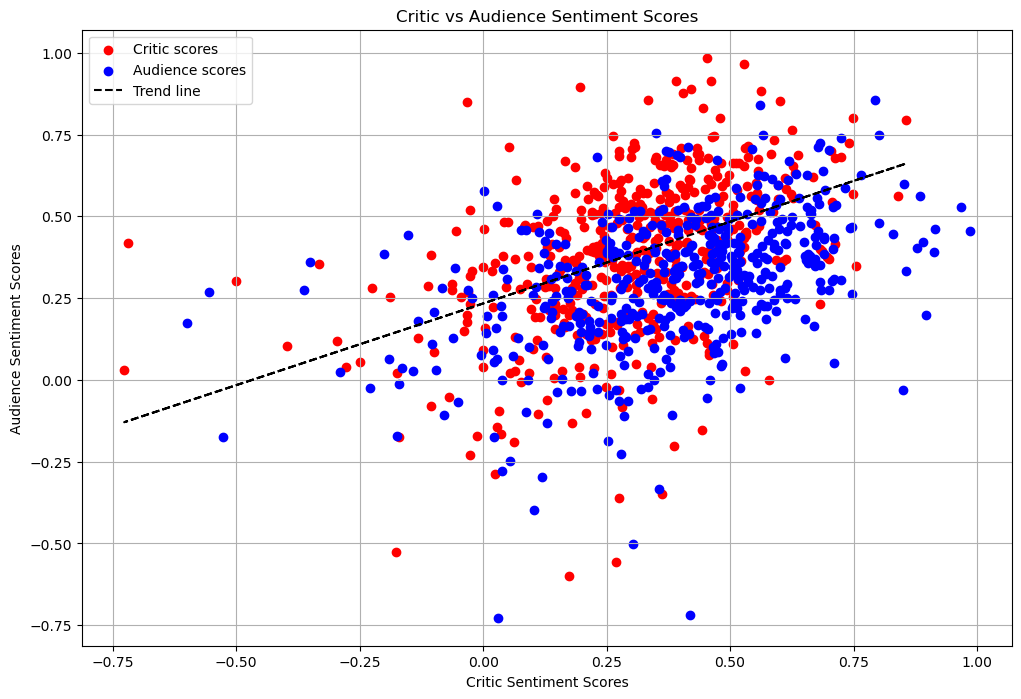

In [76]:
plt.figure(figsize=(12, 8))
plt.scatter(comparison_df['Critic Sentiment Scores'], comparison_df['Audience Sentiment Scores'], color='red', label='Critic scores')
plt.scatter(comparison_df['Audience Sentiment Scores'], comparison_df['Critic Sentiment Scores'], color='blue', label='Audience scores')

plt.title('Critic vs Audience Sentiment Scores')
plt.xlabel('Critic Sentiment Scores')
plt.ylabel('Audience Sentiment Scores')
plt.grid(True)

z = np.polyfit(comparison_df['Critic Sentiment Scores'], comparison_df['Audience Sentiment Scores'], 1)
p = np.poly1d(z)
plt.plot(comparison_df['Critic Sentiment Scores'], p(comparison_df['Critic Sentiment Scores']), color='black', linestyle='--', label='Trend line')
plt.legend()
plt.show()